# Final Assignment

In this final assignment, I will attempt an interesting kaggle competition on [insincere questions on Quora](https://www.kaggle.com/competitions/quora-insincere-questions-classification/overview).


My interest in this kaggle competition stems from the value of the final model, to identify and flag insincere questions. I have personally built a quality improvement platform for my company awhile back. While allowing users to freely contribute ideas/projects, this notion of insincereity is an eventual problem that I have to tackle.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# EDA

I will now do some EDA proper, let's look at the following:

In [3]:
df = pd.read_csv("/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 6/train.csv")
df.tail(5)

,qid,question_text,target
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


In [4]:
label1 = df[df['target']== 1]['target'].count()
label0 = df[df['target']== 0]['target'].count()

print(f'Number of labels 1: {label1}')
print(f'Number of labels 0: {label0}')
print(f'Ratio of labels 1: {label1/label0}')

Number of labels 1: 80810
Number of labels 0: 1225312
Ratio of labels 1: 0.06595054973753624


In [5]:
df['text_length'] = df['question_text'].str.len()
df.head(5)

,qid,question_text,target,text_length
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,72
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,81
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,67
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,57
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,77


In [6]:
df.iloc[[1],:]['question_text'].values[0]

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

In [7]:
df['text_length'].describe()

,text_length
count,1.306122e+06
mean,7.067884e+01
std,3.878428e+01
min,1.000000e+00
25%,4.500000e+01
50%,6.000000e+01
75%,8.500000e+01
max,1.017000e+03


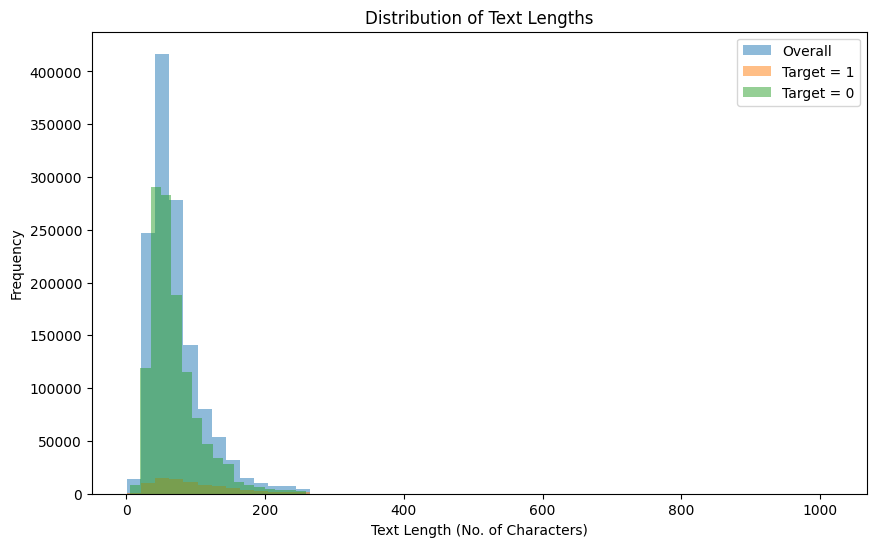

In [8]:
plt.figure(figsize=(10, 6))

plt.hist(df['text_length'], bins=50, alpha=0.5, label='Overall')
plt.hist(df[df['target'] == 1]['text_length'], bins=50, alpha=0.5, label='Target = 1')
plt.hist(df[df['target'] == 0]['text_length'], bins=50, alpha=0.5, label='Target = 0')

plt.xlabel("Text Length (No. of Characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.legend(loc='upper right')
plt.show()

In [9]:
df[df['target'] == 1]['text_length'].describe()

,text_length
count,80810.000000
mean,98.064163
std,55.186227
min,1.000000
25%,55.000000
50%,86.000000
75%,130.000000
max,1017.000000


In [10]:
df[df['target'] == 0]['text_length'].describe()

,text_length
count,1.225312e+06
mean,6.887276e+01
std,3.674032e+01
min,5.000000e+00
25%,4.400000e+01
50%,5.900000e+01
75%,8.300000e+01
max,7.520000e+02


Here we can see that there is text that is clearly erroneous.

In [11]:
df[(df['target'] == 0) & (df['text_length'] <= 5)]

,qid,question_text,target,text_length
230024,2cfd7dec2231e47afd6c,I 12?,0,5


# Preparation of dataset

We can clearly see that there is a disproportionate dataset, one that has significantly more of sincere than insincere questions. We will address this later. First of all, we need to preprocess the text.

In [12]:
STOP_WORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()

def text_processor(text):
    text = text.lower()

    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens
              if token not in string.punctuation and token not in STOP_WORDS]
    tokens = [LEMMATIZER.lemmatize(token) for token in tokens]
    processed_text = ' '.join(tokens)

    return processed_text

In [13]:
df['processed_text'] = df['question_text'].apply(text_processor)
df.head(5)

,qid,question_text,target,text_length,processed_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,72,quebec nationalist see province nation 1960s
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,81,adopted dog would encourage people adopt shop
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,67,velocity affect time velocity affect space geo...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,57,otto von guericke used magdeburg hemisphere
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,77,convert montra helicon mountain bike changing ...


In [14]:
df_sample = df.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=1108))

train_df, test_df = train_test_split(
    df_sample,
    test_size=0.2,
    random_state=1108,
    stratify=df_sample['target']
)

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

<ipython-input-14-cc4ec8f212c1>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=1108))


Training set shape: (522448, 5)
Test set shape: (130613, 5)


We will use the glove.840B.300d since it is one of the four embeddings suggested by the kaggle competition

In [15]:
texts_train = train_df['processed_text'].values
texts_test = test_df['processed_text'].values
labels_train = train_df['target'].values
labels_test = test_df['target'].values

vocab_size = 20000
max_len = 75

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts_train)

sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

x_train = pad_sequences(sequences_train, maxlen=max_len)
x_test = pad_sequences(sequences_test, maxlen=max_len)


In [16]:
actual_vocab_size = len(tokenizer.word_index)
print("Actual vocabulary size:", actual_vocab_size)

Actual vocabulary size: 116461


In [17]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip

--2025-03-03 12:57:02--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2025-03-03 12:57:03--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2025-03-03 12:57:04--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/

In [18]:
embedding_dim = 300
embedding_index = {}
glove_file = '/content/glove.840B.300d.txt'

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < embedding_dim + 1:
            continue
        word = parts[0]
        try:
            vector = np.array(parts[1:], dtype='float32')
        except ValueError:
            continue
        embedding_index[word] = vector

print(f'Found {len(embedding_index)} word vectors.')


Found 2195875 word vectors.


In [19]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Training

In [20]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(labels_train)
class_weights = compute_class_weight('balanced', classes=classes, y=labels_train)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 0.5329753286923309, 1: 8.081425566142805}


In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],
              trainable=False),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

In [ ]:
history = model.fit(
    x_train,
    labels_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, labels_test),
    class_weight=class_weight_dict
)

Epoch 1/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 1462s 178ms/step - accuracy: 0.8469 - loss: 0.3395 - val_accuracy: 0.8639 - val_loss: 0.3258
Epoch 2/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 1456s 178ms/step - accuracy: 0.8817 - loss: 0.2753 - val_accuracy: 0.8775 - val_loss: 0.3080
Epoch 3/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 1455s 178ms/step - accuracy: 0.8870 - loss: 0.2572 - val_accuracy: 0.8830 - val_loss: 0.2840
Epoch 4/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 1455s 178ms/step - accuracy: 0.8935 - loss: 0.2417 - val_accuracy: 0.8819 - val_loss: 0.2848
Epoch 5/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 1456s 178ms/step - accuracy: 0.8969 - loss: 0.2308 - val_accuracy: 0.8978 - val_loss: 0.2499
Epoch 6/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 1458s 179ms/step - accuracy: 0.8991 - loss: 0.2224 - val_accuracy: 0.8962 - val_loss: 0.2519
Epoch 7/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 1456s 178ms/step - accuracy: 0.9000 - loss: 0.2167 - val_accuracy: 0.8976 - val_loss: 0.2514
Epoch 8/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 1460s 179ms/s

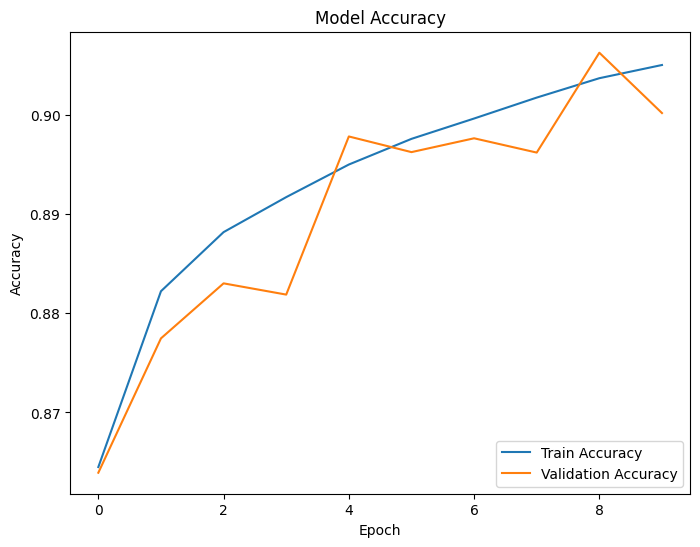

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 6/model_1.keras')

You would expect the minimal val_accuracy to be 0.93 to 0.94 because of the imbalanced dataset.

In [ ]:
model2 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],
              trainable=False),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

history2 = model2.fit(
    x_train,
    labels_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, labels_test),
    class_weight=class_weight_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

Epoch 1/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 2010s 245ms/step - accuracy: 0.8504 - loss: 0.3417 - val_accuracy: 0.8877 - val_loss: 0.2623
Epoch 2/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 2004s 246ms/step - accuracy: 0.8832 - loss: 0.2735 - val_accuracy: 0.8930 - val_loss: 0.2665
Epoch 3/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 2008s 246ms/step - accuracy: 0.8888 - loss: 0.2567 - val_accuracy: 0.8720 - val_loss: 0.3096
Epoch 4/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 2010s 246ms/step - accuracy: 0.8943 - loss: 0.2376 - val_accuracy: 0.8936 - val_loss: 0.2592
Epoch 5/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 2012s 246ms/step - accuracy: 0.8962 - loss: 0.2320 - val_accuracy: 0.9007 - val_loss: 0.2469
Epoch 6/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 2020s 247ms/step - accuracy: 0.8975 - loss: 0.2240 - val_accuracy: 0.8586 - val_loss: 0.3393
Epoch 7/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 2020s 247ms/step - accuracy: 0.9003 - loss: 0.2161 - val_accuracy: 0.8925 - val_loss: 0.2664
Epoch 8/10
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 2023s 248ms/s

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model2.save('/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 6/model_2.keras')

Future works of this project would consider distilbert which could help with semantics. The current work (present) makes use of LSTM with gloVe embeddings is likely to capture minimal semantics which is required for this task of differentiating the insincere. In the final report, what will be done better will be that the models will be run over more epochs, as you can see from the initial plotting of the val accuracy, it is still increasing but was truncated because of limited resources and the low epoch count. Bidrectional LSTM only increases the model's val_accuracy marginally.

~End